# Supervised learning

In this notebook we focus on **supervised learning**, which is a set of algorithms that take **labeled** data and try to **predict** the label using the other **features** in the data. Supervised learning so far dominates applications of machine learning, although **reinforcement learning** is catching up too. Unlike **un-supervised learning** where the data is not labeled and hence there's a lot of subjectivity, **supervised learning** algorithms, once trained on data, can easily be evaluated by just comparing their **predictions** to the **labels** (in this context, we refer to the labels sometimes as **ground truth**).

As usual, let's begin by reading some data. We use a bank marketing data, which has demographic and activity data about bank customers, as well as information about previous attempts to contact them for a marketing campain. The target `y` is binary and indicates whether the client signed up for a term deposit or not.

You can read more about the data [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

In [1]:
import pandas as pd
import numpy as np

bank = pd.read_csv("../Data/bank-full.csv", sep = ";")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Since numeric and categorical features are often pre-processed differently, we will create variables that store the names of each to make it easier to refer to them later.

In [2]:
num_cols = bank.select_dtypes(['integer', 'float']).columns
cat_cols = bank.select_dtypes(['object']).drop(columns = "y").columns

print("Numeric columns are {}.".format(", ".join(num_cols)))
print("Categorical columns are {}.".format(", ".join(cat_cols)))

Numeric columns are age, balance, day, duration, campaign, pdays, previous.
Categorical columns are job, marital, education, default, housing, loan, contact, month, poutcome.


As usual before we can proceed to machine learning, we need to get the data ready. And since we're doing supervised learning, we need to set aside a test data so we can later evaluate the model using that data. So let's begin by splitting the data.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bank.drop(columns = "y"), bank["y"], 
                                                    test_size = 0.15, random_state = 42)

In [4]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [5]:
print(f"Training data has {X_train.shape[0]} rows.")
print(f"Test data has {X_test.shape[0]} rows.")

Training data has 38429 rows.
Test data has 6782 rows.


Before we begin our journey of trying out different algorithms in `sklearn` we do need to encode our categorical features.

In [6]:
from sklearn.preprocessing import OneHotEncoder

onehoter = OneHotEncoder(sparse = False, drop = "first")
onehoter.fit(X_train[cat_cols])
onehot_cols = onehoter.get_feature_names(cat_cols)
X_train_onehot = pd.DataFrame(onehoter.transform(X_train[cat_cols]), columns = onehot_cols)
X_test_onehot = pd.DataFrame(onehoter.transform(X_test[cat_cols]), columns = onehot_cols)

Some algorithms we're going to use (such as decision tree) won't require that we normalize our numeric features, but most will. Not doing so won't break the algorithm, but just as we saw in the case of k-means, it will skew the results. So let's Z-normalize our numeric features now.

In [7]:
from sklearn.preprocessing import StandardScaler

znormalizer = StandardScaler()
znormalizer.fit(X_train[num_cols])
X_train_norm = pd.DataFrame(znormalizer.transform(X_train[num_cols]), columns = num_cols)
X_test_norm = pd.DataFrame(znormalizer.transform(X_test[num_cols]), columns = num_cols)
X_train_norm.head()

,age,balance,day,duration,campaign,pdays,previous
0,1.135454,-0.441514,1.342893,1.905285,-0.565758,-0.410605,-0.246723
1,0.193989,-0.393007,1.463034,0.127461,1.355238,-0.410605,-0.246723
2,-1.312355,-0.500045,1.583175,-0.685592,0.394740,-0.410605,-0.246723
3,-0.088451,-0.382982,-0.459220,-0.654471,1.035072,-0.410605,-0.246723
4,0.005696,-0.441514,-0.819643,-0.747835,0.074574,-0.410605,-0.246723


We now join our numeric features and our one-hot-encoded categorical features into one data set that we pass to the decision tree classifier.

In [8]:
X_train_featurized = X_train_onehot # add one-hot-encoded columns
X_test_featurized = X_test_onehot   # add one-hot-encoded columns
X_train_featurized[num_cols] = X_train_norm # add numeric columns
X_test_featurized[num_cols] = X_test_norm   # add numeric columns

del X_train_norm, X_test_norm, X_train_onehot, X_test_onehot

print("Featurized training data has {} rows and {} columns.".format(*X_train_featurized.shape))
print("Featurized test data has {} rows and {} columns.".format(*X_test_featurized.shape))

Featurized training data has 38429 rows and 42 columns.
Featurized test data has 6782 rows and 42 columns.


## Decision tree classifier

With our data ready, we can now train a decision tree classifier. There is a lot of detail that we leave for another time, but in this lesson we want you to see the common pattern to all or most supervised learning algorithms: 

1. We create an **instance** of the algorithm, along with any settings we want to use. Here we instantiate a `DecisionTreeClassifier` and specify `max_depth = 10`.
1. We train the algorithm on the training data by calling the `fit` method.
1. Once the model is trained, we obtain prediction by calling the `predict` method. This method is similar to the  `transform` method for the pre-processing examples we saw in prior lessons, in that you give it a data, and it uses the trained model to run predictions on the data. We want predictions for both the training and test data, so we call `predict` twice. 

In [9]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth = 15)
dtree.fit(X_train_featurized, y_train)

y_hat_train = dtree.predict(X_train_featurized)
y_hat_test = dtree.predict(X_test_featurized)

Usually we are only interested in evaluating the model on the test data. But when we have many models we are comparing, it's useful to evaluate each model on both the training and test data. We will see in the next lecture why.

In [10]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

Accuracy on the training data: 96%.
Accuracy on the test data: 90%.


### Exercise (5 minutes)

We will talk in a future lecture about all different ways to evaluate classification models, but in the above snippet we are using **accuracy**, which is the percentage of predictions that match the true labels. In other words, the percentage of rows $i$ where $Y_i = \hat Y_i$, where $Y_i$ is the $i$ target value, and $\hat Y_i$ is the $i$th model's prediction for that value.

- Return to the `DecisionTreeClassifier` above and try some larger and smaller value for `max_depth`. What do you notice about the accuracy of the training and test data as you change `max_depth`? We can use `max_depth` to "fiddle" with the model we get: `max_depth` is an example of what we call a **hyper-parameter** and the task of fiddling with a model's hyper-parameter is called **hyper-parameter tuning**.
- Every algorithm has hyper-parameters. Most are unique to the algorithm: for example `max_depth` is unique to tree-based algorithms like decision trees and random forests. Return to the classifier above and look up what some other hyper-parameters are?

### End of exercise

So we know how accurate our model is, but what if we want to know which features contributed the most to the model? We passed a lot of features to the model, but most likely, a lot of those features were not really that useful to the prediction. Foretunately, decision trees also return **feature importance** values. Note that numeric features correspond to the numeric columns in the data. However, since we one-hot-encoded the categorical features, *every category* of every categorical column in the original data gets its own feature.

Here's how we can plot the top 10 most important features to the model, starting with the most important features at the top.

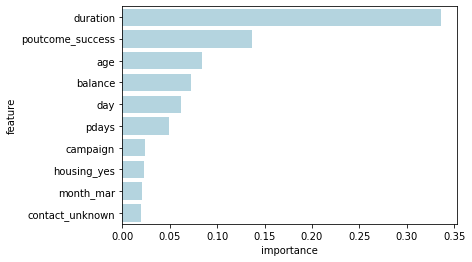

In [11]:
df_var_imp = pd.DataFrame({"feature": X_train_featurized.columns, 
                           "importance": dtree.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

import seaborn as sns
ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp.head(10), color = "lightblue")

Even though we didn't plot it, when we use decision trees to train model a model, the trained model is (you guessed it!) a tree! This means that to get a prediction for any new data, we start at the top of the tree (called the **root**) and based on the data values we ultimately finish in one of the **leaves** of the tree, at which point we predict whatever the prediction is at the leaf we ended in.

## k-nearest neighbor classifier

A model trained using the k-nearest neighbor algorithm on the other hand is very different. It doesn't have a tree structure. Instead it labels a new data point by averaging the labels of the $k$ points nearest to it. For a numeric target, averaging can be done using the mean function. For categorical target, averaging means some sort of majority vote.

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knnb = KNeighborsClassifier(n_neighbors = 25)
knnb.fit(X_train_featurized, y_train)

y_hat_train = knnb.predict(X_train_featurized)
y_hat_test = knnb.predict(X_test_featurized)

Let's evaluate the model:

In [32]:
acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

Accuracy on the training data: 90%.
Accuracy on the test data: 90%.


### Exercise (5 minutes)

- The `KNeighborsClassifier` classifier has a hyper-parameter called `n_neighbors`. Try a few different values and report how it affects the accuracy on training and test data. Are you more likely to overfit if you choose a smaller value or a larger one?
- The `KNeighborsClassifier` classifier has another hyper-parameter called `weights`. [Read up](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on what this hyper-parameter does and change its value to something other than the default value. How does this affect your results?
- Instead of calling the `predict` method to get predictions, in the cell below call the `predict_proba` method and examine the results. How do the results returned by the `predict` and `predict_proba` methods relate to each other? HINT: It's not enough to examine the results by just looking at them, so see if you can use `np.argmax` to give a defininitive answer.

In [35]:
knnb.predict_proba(X_test_featurized)

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.96, 0.04],
       ...,
       [0.76, 0.24],
       [1.  , 0.  ],
       [1.  , 0.  ]])

In [36]:
np.argmax(knnb.predict_proba(X_test_featurized), axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
knnb.predict(X_test_featurized)

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

Decision trees also have a method called `predict_proba`. Calling `predict` returns what we call **hard predictions** and calling `predict_proba` returns **soft predictions**.

### End of exercise

## Logistic regression classifier

The decision tree and k-nn algorithms could be used for both classification and regression, with some slight modifications. The logistic regression algorithm is another popular algorithm, but it is only used for classification. Careful here: even though it has the word **regression** in it, logistic regression is a **classification** algorithm, not a **regression** algorithm. A model trained using logistic regression predicts new classes using an **equation**. This makes logistic regression very efficient. In fact, once you have your trained model, you can pull out the equation's **coefficients** and implement it even in SQL: in just one query, although if we have a lot of features it could be long query!

In [16]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter = 5000)
logit.fit(X_train_featurized, y_train)

y_hat_train = logit.predict(X_train_featurized)
y_hat_test = logit.predict(X_test_featurized)

Let's evaluate the model:

In [17]:
acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

Accuracy on the training data: 90%.
Accuracy on the test data: 90%.


So what does trained model's equation look like. To get the acutal equation we need to do some string processing with Python. Of course to get the predictions, we don't need to manually create the equation: we just need to call the `predict` method. But if we insisted on seeing the equation, we can run the next cell. 

**Note:** this equation gives what is called the **log-odds ratio**, and with an additional transformation that we skipped here, we can get the probability $P(Y_i = 1)$ from the log-odds ratio.

In [18]:
variables = list(X_train_featurized.columns)
coefficients = map(str, list(logit.coef_[0]))
intercept = logit.intercept_[0]

var_coef_pairs = list(zip(variables, coefficients))
equation = str(intercept) + " + \n" + " + \n".join([v + " * " + c for v,c in var_coef_pairs])
print(equation)

-1.4396585212400648 + 
job_blue-collar * -0.3016501613474136 + 
job_entrepreneur * -0.30693404015257597 + 
job_housemaid * -0.45863172176192324 + 
job_management * -0.13031246994388257 + 
job_retired * 0.21897374623294158 + 
job_self-employed * -0.2326618592801927 + 
job_services * -0.1992818518690783 + 
job_student * 0.3263207743515512 + 
job_technician * -0.19102922360988747 + 
job_unemployed * -0.18328459342437314 + 
job_unknown * -0.3491925353914526 + 
marital_married * -0.16719716956675337 + 
marital_single * 0.11386232487553828 + 
education_secondary * 0.17425345456172803 + 
education_tertiary * 0.343538576633752 + 
education_unknown * 0.19602817792456784 + 
default_yes * -0.06258227957602741 + 
housing_yes * -0.6896076803626983 + 
loan_yes * -0.4192097843688744 + 
contact_telephone * -0.1640727407736477 + 
contact_unknown * -1.6608857479040269 + 
month_aug * -0.6896864367394948 + 
month_dec * 0.585920554885654 + 
month_feb * -0.18228147352777707 + 
month_jan * -1.226737197855014

Note that the absolute value of the **coefficients** in the above equation can be thought of as a measure of importance of its corresponding feature, similar to the **feature importance** metric we saw with decision trees. However this is only true if the features are normalized! 

## Linear regression regressor

So far we've only seen classification algorithms. So it's time to change course and take a look at regression algorithms. For that we need to find a numeric target. We can use the `duration` column in the data as our target.

In [37]:
y_train = X_train_featurized['duration']
X_train_featurized = X_train_featurized.drop(columns = 'duration')

y_test = X_test_featurized['duration']
X_test_featurized = X_test_featurized.drop(columns = 'duration')

Other than changing the target from categorical to numeric, we don't have to do things very differently from before. The training and predicting part of the code remain very similar. 

In [38]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_featurized, y_train)

y_hat_train = linreg.predict(X_train_featurized)
y_hat_test = linreg.predict(X_test_featurized)

One difference is that regression algorithms are evaluated using different metrics from classification algorithms. We used **accuracy** for the classification algorithms we saw above. We use **RMSE** for the regression algorithms we train below. We can also choose other metrics as long as they're relevant to regression.

In [39]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, y_hat_train) ** 0.5
rmse_test = mean_squared_error(y_test, y_hat_test) ** 0.5

print("RMSE on the training data: {:5.5f}.".format(rmse_train))
print("RMSE on the test data: {:5.5f}.".format(rmse_test))

RMSE on the training data: 0.99093.
RMSE on the test data: 1.00535.


### Exercise (5 minutes)

To get MSE (mean squared error), here's what we need to do:

- find the **errors** (difference between predicted and actual value) and square them to get **squared errors**
- add up all the squared errors to get the **sum of squared errors**
- divide the sum of squared errors by the number of rows to get the **mean squared error**

- Use the training data to calculate the MSE using `numpy` and compare it to what you get when you run `mean_squared_error`. If you use `numpy` correctly, you should not have to write any loops.

In [49]:
rmse_train_stratch = ((((y_train - y_hat_train) ** 2).sum())/y_train.size)**0.5
rmse_test_stratch = ((((y_test - y_hat_test) ** 2).sum())/y_test.size)**0.5

print("RMSE on the training data: {:5.5f}.".format(rmse_train_stratch))
print("RMSE on the test data: {:5.5f}.".format(rmse_test_stratch))

RMSE on the training data: 0.99093.
RMSE on the test data: 1.00535.


Note that the RMSE stands for **root mean squared error**, which is the square root of the MSE.

### End of exercise

The next algorithm we're going to try is a neural network. Neural networks are considered complex algorithms, which means that (1) they will consume a lot of compute, (2) it's very easy to overfit with them, and (3) they are not a good option if we care about explainability. 

Neural networks take the data and compute their own features, and they compute an increasingly complex set of features because they are composed of layers. The features created in earlier layers affect the ones in later layers, allowing for increased complexity. In a way, you can say neural networks do their own feature engineering and are really good at it. This is one of their greatest strenth, but it also means they are very data hungry. There is no free lunch in data science and machine learning. The neural network we're going to use here will only have a few **hidden layers**, and the number of hidden neurons in each layer is a hyperparameter that can be specified. Neural networks with lots of hidden layers take us into the topic of **deep learning** and instead of `sklearn` we would need to start using libraries like `tensorflow` or `pytorch` (they are also called **frameworks**) on top of GPU machines to be able to handle the computational workload.

In [54]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes = [20, 10, 10, 5, 3, 2], early_stopping = False)
nn.fit(X_train_featurized, y_train)

y_hat_train = nn.predict(X_train_featurized)
y_hat_test = nn.predict(X_test_featurized)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [55]:
rmse_train = mean_squared_error(y_train, y_hat_train) ** 0.5
rmse_test = mean_squared_error(y_test, y_hat_test) ** 0.5

print("RMSE on the training data: {:5.5f}.".format(rmse_train))
print("RMSE on the test data: {:5.5f}.".format(rmse_test))

RMSE on the training data: 0.94061.
RMSE on the test data: 1.04254.


### Exercise (5 minutes)


- Change the number of hidden layers from 50 to 200. How does this affect runtime and RMSE?
- Let's now train a neural network with two hidden layers instead of one. To do that, we need to provide a **list of integers** to `hidden_layer_sizes` instead of a single integer. The first integer in the list will be the number of hidden neurons in the first layer, the second integer will be  the number of hidden neurons in the second layer, and so on. **So the size of this list will be the number of hidden layers.** The more hidden layers we have the **deeper** the network. But we must be careful because adding hidden layers can increase runtime dramatically! So keep the number of hidden neurons in each layer below 20. What is the effect of adding hidden layers on overfitting?

### End of exercise

Neural networks can capture very complex relationships, but they can overfit very easily. Tuning the hyper-parameters of a neural network is not an easy task. Hyper-parameters like number of hidden layers and number of hidden neurons per layer affect the neural network's **architecture**.

# Assignment (Milestone 3)

We saw a few examples of machine learning algorithms, so at this point it seems like once you get the data ready, machine learning is just "plug and play", but not so fast! 

In this assignment, we learn about **regularization**! Regularization is a means by which we can control how much a machine learning algorithm learns. The controlling is done using a parameter that the algorithm, called the **shrinkage parameter**, which is just an argument of the algorithm. The shrinkage parameter is an example of a **hyper-parameter**. A hyper-parameter is like a knob: by specifying a different value for the hyper-parameter, we control how the training happens, a process called **hyper-parameter tuning**. We talk about this is more detail in the next lesson.

We will look at two examples of regularizaiton: LASSO and Ridge regression. Both LASSO and Ridge regression are implementations of linear regression where we try to minimize prediction error plus some penalty that depends on the model's parameters (or coefficients) and the shrinkage constant (`alpha` in the code below). LASSO penalizes the model's parameters using the sum of the **absolute values** of the parameters (this is also called **L1-regularization**), while Ridge does so based on the sum of the **squared values** of the parameters (this is also called **L2-regularization**). For reasons we cannot elaborate on here, **LASSO has the by-product that it also does feature selection**, whereas Ridge doesn't. So not all regularization results in feature selection.

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_housing = pd.read_csv("../Data/boston-house-prices.csv", skiprows = 1)
df_housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Here's the description of the data:

- `CRIM`: per capita crime rate by town
- `ZN`: proportion of residential land zoned for lots over 25,000 sq.ft.
- `INDUS`: proportion of non-retail business acres per town.
- `CHAS`: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- `NOX`: nitric oxides concentration (parts per 10 million)
- `RM`: average number of rooms per dwelling
- `AGE`: proportion of owner-occupied units built prior to 1940
- `DIS`: weighted distances to five Boston employment centres
- `RAD`: index of accessibility to radial highways
- `TAX`: full-value property-tax rate per \$10,000
- `PTRATIO`: pupil-teacher ratio by town
- `B`: $1000(Bk - 0.63)^2$ where $Bk$ is the proportion of black residents by town
- `LSTAT`: % lower status of the population
- `MEDV`: Median value of owner-occupied homes in $1000's

To see how regularization works, let's return to the model we trained in the lab from the data above.

In [82]:
X = df_housing.drop(columns = 'MEDV')
y = df_housing['MEDV']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.416942,0.344513,-1.117966,-0.270395,-0.960137,0.943640,-1.102673,0.654891,-0.523106,-1.144555,-1.601746,0.398294,-1.108176
1,-0.280002,-0.499723,-0.421068,-0.270395,-0.145806,-0.222195,0.832605,0.069475,-0.638367,-0.601866,1.175568,0.448420,0.863237
2,-0.408091,-0.499723,-0.360216,-0.270395,-0.299938,0.679704,0.108207,-0.448063,-0.523106,-0.142668,1.130038,0.434251,-0.678455
3,-0.359270,0.344513,-1.025240,-0.270395,0.171021,1.652175,-0.555824,-0.440721,-0.523106,-0.858301,-2.466811,0.377578,-1.307689
4,-0.000352,-0.499723,1.021988,-0.270395,0.239524,0.017747,-0.580681,0.076309,1.666847,1.539070,0.811330,0.359545,-0.272453


1. Train a linear regression algorithm to predict `MEDV` from the remaining features. <span style="color:red" float:right>[1 point]</span>

Reasoning - Need to import the linear regression model to train based on the X and y provided above

In [83]:
from sklearn.linear_model import LinearRegression

linreg=LinearRegression()
linreg.fit(X_train, y_train)

y_linreg_train = linreg.predict(X_train)
y_linreg_test = linreg.predict(X_test)

Conclusion - Was able to train the X and y based on the medv by using the linear regression fit

2. Evaluate the model and report the performance on both training and test data. These numbers will serve as our benchmark performance. <span style="color:red" float:right>[2 point]</span>

Need to change the 

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

Reasoning - Will import the mean_squared_error package from sklearn to get the idea of the performance and then square that to get it into the correct format

In [84]:
from sklearn.metrics import mean_squared_error


rmse_train = mean_squared_error(y_train, y_linreg_train) **0.5
rmse_test = mean_squared_error(y_test, y_linreg_test) **0.5

print("Accuracy on the training data: {:5.3f}.".format(rmse_train))
print("Accuracy on the test data: {:5.3f}.".format(rmse_test))

Accuracy on the training data: 4.768.
Accuracy on the test data: 3.872.


Conclusion - Able to get the accuracy, both were relatively close with each other

We now train a regularized version of `LinearRegression` called `Lasso` (you can load it from the same library). `Lasso` has an argument called `alpha`, which is the **shrinkage parameter** we referred to earlier.

3. Let `alpha = 0.000001` and train a `Lasso` algorithm. Show that the resulting model is practically identical to the one we trained with `LinearRegression`. There are different ways to show this, so you will need to think of a way. <span style="color:red" float:right>[2 point]</span>

Reasoning - will need to import the Lasso algorithm and then train the same data on this method, will copy the rmse for the data but run it over the lassoo data

In [85]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.000001)

lasso_reg.fit(X_train, y_train)

y_lasso_train = lasso_reg.predict(X_train)

y_lasso_test = lasso_reg.predict(X_test)


rmse_train_lasso = mean_squared_error(y_train, y_lasso_train) **0.5
rmse_test_lasso = mean_squared_error(y_test, y_lasso_test) **0.5

print("Accuracy on the training data: {:5.3f}.".format(rmse_train_lasso))
print("Accuracy on the test data: {:5.3f}.".format(rmse_test_lasso))

Accuracy on the training data: 4.768.
Accuracy on the test data: 3.872.


Conclusion - should they be the same? A little confused on this, or are we learning how similar methods can be?

4. Iteratively train a new `Lasso` model, letting `alpha` change each time to one of the values given by `alpha_vals` below, keeping track of the performance on the training and test data each time, and storing the model's coefficients each time (the `coef_` attribute of the trained model). <span style="color:red" float:right>[5 point]</span>

To make it easier, we have laid out general layout of the code. You can use this if you want or write your own program.

Reasoning - Will follow the directions pretty closely, I will first train the lasso model with an alpha of 

In [86]:
lasso_reg_4 = Lasso(alpha=0.000001)

lasso_reg_4.fit(X_train, y_train)

y_lasso_train = lasso_reg_4.predict(X_train)

y_lasso_test = lasso_reg_4.predict(X_test)

In [87]:
alpha_vals = np.arange(0.01, 5, .01) # values of alpha we want to iterate over
# this data stores the alpha we tried, and the coefficients (coef) we got for each feature (col)
iter_coefs = pd.DataFrame(columns = ['alpha', 'col', 'coef'])
iter_train_perf = [] # use this to store training data performance for each iteration
iter_test_perf = [] # use this to store test data performance for each iteration



for i in alpha_vals:
    lasso_reg_4 = Lasso(alpha=i)
    lasso_reg_4.fit(X_train, y_train)
    y_lasso_train = lasso_reg_4.predict(X_train)
    y_lasso_test = lasso_reg_4.predict(X_test)
    rmse_train = mean_squared_error(y_train, y_lasso_train) **0.5
    rmse_test = mean_squared_error(y_test, y_lasso_test) **0.5
    iter_train_perf.append(rmse_train)
    iter_test_perf.append(rmse_test)
    for j in range(len(X_train.columns)):
        iter_coefs = iter_coefs.append({'alpha': i, 'col':(X_train.columns[j]), 'coef':lasso_reg_4.coef_[j]},ignore_index=True)

# loop over the alpha values and do this:
    # fit a model with alpha
    # evaluate the model on training and test data
    # append training performance to iter_train_perf
    # append test performance to iter_test_perf
    # create a DataFrame storing alpha (repeated), feature name matching coefficient
    # append the above DataFrame to iter_coefs
    
    ###ignoreindex=False

Conclusion - it worked so I will count it as a win, just followed the directions and then added it to the columns

5. Using a visual, show how the performance on the training and test data changed as we gradually increased `alpha`. <span style="color:red" float:right>[2 point]</span>

Reasoning - will first take a look at the data and organize it and then use plt to make a basic visualization

In [88]:
import pandas as pd
iter_perf = pd.DataFrame(iter_train_perf, columns = ['train_rmse'])

iter_perf['test_rmse']=iter_test_perf
iter_perf['alpha']=((iter_perf.index+1)/100)

In [89]:
print(iter_perf.head())
print(iter_perf.shape)

   train_rmse  test_rmse  alpha
0    4.769179   3.864341   0.01
1    4.771164   3.858193   0.02
2    4.773882   3.853969   0.03
3    4.777247   3.854448   0.04
4    4.781567   3.856379   0.05
(499, 3)


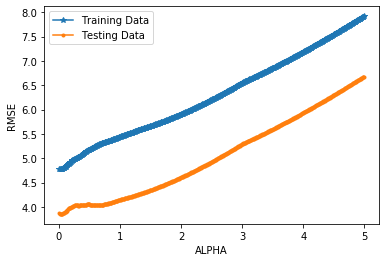

In [90]:
fig,axis = plt.subplots()

axis.plot(iter_perf.alpha, iter_perf.train_rmse, marker="*", label='Training Data')

axis.plot(iter_perf.alpha, iter_perf.test_rmse, marker=".", label='Testing Data')

axis.set_xlabel('ALPHA')
axis.set_ylabel('RMSE')

axis.legend()
plt.show()

Conclusion - Found that the training and testing data were relatively similar in terms of their slopes

6. Using a visual, show how the model's coefficients changed as we gradually increased the shrinkage parameter `alpha`. HINT: They should appear to be shrinking toward zero as you increase `alpha`! <span style="color:red" float:right>[2 point]</span>

Reasoning - same concept as above but will not need to do any data organization on this one, will just plot

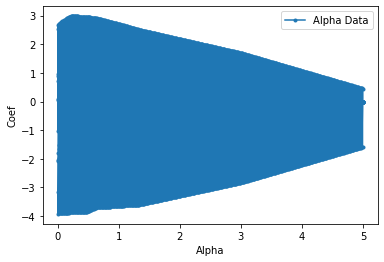

In [91]:
fig,axis = plt.subplots()
axis.plot(iter_coefs.alpha, iter_coefs.coef, marker=".", label='Alpha Data')

axis.set_xlabel('Alpha')
axis.set_ylabel('Coef')
axis.legend()
plt.show()

Conclusion - Able to fnd a sloping alpha

6. Show that `Ridge` and `Lasso` return the same trained model when `alpha = 0.00001` (i.e. close to zero). <span style="color:red" float:right>[2 point]</span>

Reasoning - WIll just switch from Lasso to Ridge on this one from earlier

In [92]:
from sklearn.linear_model import Ridge

ridgereg = Ridge(alpha=0.00001)
ridgereg.fit(X_train, y_train)
y_train_ridge = ridgereg.predict(X_train)
y_test_ridge = ridgereg.predict(X_test)

In [93]:
rmse_ridge_train = mean_squared_error(y_train, y_train_ridge)**0.5
rmse_ridge_test = mean_squared_error(y_test, y_test_ridge)**0.5

In [94]:
print("Accuracy on the training data: {:5.3f}.".format(rmse_ridge_train))
print("Accuracy on the test data: {:5.3f}.".format(rmse_ridge_test))

Accuracy on the training data: 4.768.
Accuracy on the test data: 3.872.


Conclusion - Again, same values for training and test data

7. Repeat step 4 this time using `Ridge` instead of `Lasso`. We will use the following range for `alpha`: <span style="color:red" float:right>[2 point]</span>

Reasoning - same concept as 4, will just drag the code down from above and make slight modifications

In [95]:
alpha_vals_ridge = np.arange(0.01, 5, .01) # values of alpha we want to iterate over
iter_coefs_ridge = pd.DataFrame(columns = ['alpha', 'col', 'coef'])
iter_train_perf_ridge = [] # use this to store training data performance for each iteration
iter_test_perf_ridge = [] # use this to store test data performance for each iteration



for i in alpha_vals_ridge:
    ridge_reg = Ridge(alpha=i)
    ridge_reg.fit(X_train, y_train)
    y_ridge_train = ridge_reg.predict(X_train)
    y_ridge_test = ridge_reg.predict(X_test)
    rmse_train_ridge = mean_squared_error(y_train, y_ridge_train) **0.5
    rmse_test_ridge = mean_squared_error(y_test, y_ridge_test) **0.5
    iter_train_perf_ridge.append(rmse_train_ridge)
    iter_test_perf_ridge.append(rmse_test_ridge)
    for j in range(len(X_train.columns)):
        iter_coefs_ridge = iter_coefs_ridge.append({'alpha': i, 'col':(X_train.columns[j]), 'coef':ridge_reg.coef_[j]},ignore_index=True)

Conclusion - It worked so again, I hope that it was correctly coded

8. Using a visual, show how the performance on the training and test data changed as we gradually increased `alpha`. <span style="color:red" float:right>[1 point]</span>

Reasoning - will drag the code down from above again after organizing

In [96]:

iter_perf_ridge = pd.DataFrame(iter_train_perf_ridge, columns = ['train_rmse'])

iter_perf_ridge['test_rmse']=iter_test_perf_ridge
iter_perf_ridge['alpha']=((iter_perf_ridge.index+1))

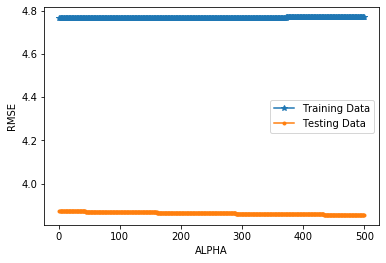

In [97]:
fig,axis = plt.subplots()

axis.plot(iter_perf_ridge.alpha, iter_perf_ridge.train_rmse, marker="*", label='Training Data')

axis.plot(iter_perf_ridge.alpha, iter_perf_ridge.test_rmse, marker=".", label='Testing Data')

axis.set_xlabel('ALPHA')
axis.set_ylabel('RMSE')

axis.legend()
plt.show()

Conclusion - Quite interested by my results to be honest, something doesnt seem right

9. Using a visual, show how the model's coefficients changed as we gradually increased the shrinkage parameter `alpha`.  <span style="color:red" float:right>[1 point]</span>

Reasoning - will run a similar plot to earlier

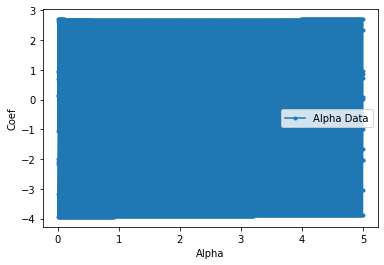

In [80]:
fig,axis = plt.subplots()
axis.plot(iter_coefs_ridge.alpha, iter_coefs_ridge.coef, marker=".", label='Alpha Data')

axis.set_xlabel('Alpha')
axis.set_ylabel('Coef')
axis.legend()
plt.show()

Conclusion - Again, a little confused by these results

10. Based on the results, briefly describe the effect of changing `alpha` on the coefficients of both `Ridge` and `Lasso`. What value of `alpha` would you choose for each case? You do not need to give a precise answer, but choose a number. <span style="color:red" float:right>[2 point]</span>

The alpha choice seems to be an important aspect of the data management, 


#https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

# End of assignment